In [ ]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
import re

### initCelebA, class

In [ ]:
def initialize_celeba(CELEBA_IMAGES = 30000):
    global output_file_path, output_low_level_path, df_attributes
    # output_file_path = "../../data/attribute classifier/celeba/"
    output_file_path = "/content/drive/MyDrive/project-sepnu/data/attribute classifier/celeba/"
    # output_low_level_path = "../../data/low level/celeba/"
    output_low_level_path = "/content/drive/MyDrive/project-sepnu/data/low level/celeba/"
    map_attributes_features_path = output_file_path + "map_attributes_features.txt"
    # attributes_path = "../../../CelebA/metadata/list_attr_celeba.csv"
    # attributes_path = "/content/drive/MyDrive/CelebA/metadata/list_attr_celeba.txt"
    attributes_path = "/content/drive/MyDrive/CelebA/metadata/list_attr_celeba.csv"
    # if not os.path.exists(map_attributes_features_path):
    #     file_attributes = open(attributes_path, "r"); file_map_attributes_features = open(map_attributes_features_path, "w")
    #     for attribute in file_attributes.readline().replace("\n", "").split(",")[1:]:
    #         file_map_attributes_features.write(attribute + ":" + input("Enter space separated features for the attribute \"%s\": " % (attribute, )) + "\n")
    #     file_attributes.close(); file_map_attributes_features.close()
    # file_map_attributes_features = open(map_attributes_features_path, "r")
    # global map_attributes_features
    # for attribute, features in [line.split(":") for line in file_map_attributes_features.readlines()]:
        # map_attributes_features[attribute] = features.split()
    # file_map_attributes_features.close()
    # df_attributes = pd.read_csv(attributes_path)[:CELEBA_IMAGES] 
    # asdf = open(attributes_path, 'r')
    # asdf = asdf.readlines()
    # print(asdf[:10])
    # return
    df_attributes = pd.read_csv(attributes_path) 
    # print(df_attributes.shape)
    removeImages = df_attributes.shape[0] - CELEBA_IMAGES
    drop_indices = np.random.choice(df_attributes.index[1:], removeImages, replace=False)
    # drop_indices = drop_indices + 1
    # print(df_attributes.shape[0])
    df_attributes = df_attributes.drop(drop_indices)     
    # print(df_attributes.shape[0])
    # print(df_attributes)
    return df_attributes
    # assert df_attributes.shape[0] == np.load(output_low_level_path + "rgb_chin.npy").shape[0]


In [ ]:
class celebAData(Dataset):
    def __init__(self,df_attributes,transform=None,train=True):
        super().__init__()
        self.df_attributes = df_attributes
        self.transform = transform
        self.train = train
        self.data_list = df_attributes['image_id'].tolist()
        # celeba_id = df['image_id'].tolist()

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,item):
        # global output_file_path, output_low_level_path, df_attributes
        # print(item)
        img_idx = item
        imgname = self.data_list[item]
        # foldername = imgname[:-9]
        # imgpath = os.path.join('/content/drive/MyDrive/LFW/zipped/lfw',foldername,imgname)
        imgpath = os.path.join("/content/img_align_celeba/img_align_celeba", imgname)
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        imgr = cv2.resize(img,(256,256))
        label = self.df_attributes.iloc[img_idx][1:]
        # label = max(label,0)

        if self.transform is not None:
            imgr = self.transform(imgr)
        if self.train:
          return {
              'img' : imgr,
              'label' : torch.tensor(label)
          }
        else:
          return {
              'img':imgr
          }
        

### AlexNet


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, attributesConsidered):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(12544, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, attributesConsidered),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        
        return x

In [ ]:
def get_resnet(attributesConsidered):
    model1 = models.resnet50(pretrained=True)
    for name, child in model1.named_children():
        for param in child.parameters():
            param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model1.fc.in_features
    model1.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, attributesConsidered))

    return model1

In [ ]:
class MultiOutputModel(nn.Module):
    def __init__(self):
        super().__init__()
        
	        resnet = models.resnext50_32x4d(pretrained=True)
	        resnet.fc = nn.Sequential(
	            nn.Dropout(p=0.2),
	            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
	        )
	        self.base_model = resnet
	        self.sigm = nn.Sigmoid()
        # self.base_model = models.mobilenet_v2().features  # take the model without classifier
        # last_channel = models.mobilenet_v2().last_channel # size of the layer before the classifier

        # # the input for the classifier should be two-dimensional, but we will have
        # # [<batch_size>, <channels>, <width>, <height>]
        # # so, let's do the spatial averaging: reduce <width> and <height> to 1
        # self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # # create separate classifiers for our outputs
        # self.attr0 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr1 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr2 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr3 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr4 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr5 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr6 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr7 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr8 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))
        # self.attr9 = nn.Sequential(nn.Dropout(p=0.2),nn.Linear(in_features=last_channel, out_features=2))

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, start_dim=1)

        # outs = {i: 0 in range(10)}
        # for i in outs:
        #     outs[i] = self.
        # out = [self.attr0(x), self.attr1(x), self.attr2(x), self.attr3(x), self.attr4(x), self.attr5(x), self.attr6(x), self.attr7(x), self.attr8(x), self.attr9(x)]

        # {
        #     0: self.attr0(x),
        #     1: self.attr1(x),
        #     2: self.attr2(x),
        #     3: self.attr3(x),
        #     4: self.attr4(x),
        #     5: self.attr5(x),
        #     6: self.attr6(x),
        #     7: self.attr7(x),
        #     8: self.attr8(x),
        #     9: self.attr9(x)
        # }
        # print(np.asarray(out).shape)
        out = self.attr0(x)
        out = torch.cat((out, self.attr1(x)), 1)
        out = torch.cat((out, self.attr2(x)), 1)
        out = torch.cat((out, self.attr3(x)), 1)
        out = torch.cat((out, self.attr4(x)), 1)
        out = torch.cat((out, self.attr5(x)), 1)
        out = torch.cat((out, self.attr6(x)), 1)
        out = torch.cat((out, self.attr7(x)), 1)
        out = torch.cat((out, self.attr8(x)), 1)
        out = torch.cat((out, self.attr9(x)), 1)
        print(out.shape)
        return out
    def get_loss(self, outputs, labels):
        loss = 0 
        for i in range(9):
            loss = loss + F.cross_entropy(outputs[:,i], labels[:,i])
        
        # loss = color_loss + gender_loss + article_loss
        # return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}
        return loss


In [ ]:
class MultiOutputModel(nn.Module):
    def __init__(self):
        super().__init__(n_classes)        
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        out = self.attr0(x)
        out = torch.cat((out, self.attr1(x)), 1)
        out = torch.cat((out, self.attr2(x)), 1)
        out = torch.cat((out, self.attr3(x)), 1)
        out = torch.cat((out, self.attr4(x)), 1)
        out = torch.cat((out, self.attr5(x)), 1)
        out = torch.cat((out, self.attr6(x)), 1)
        out = torch.cat((out, self.attr7(x)), 1)
        out = torch.cat((out, self.attr8(x)), 1)
        out = torch.cat((out, self.attr9(x)), 1)
        print(out.shape)
        # loss = color_loss + gender_loss + article_loss
        # return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}
        return loss


### random


(30000, 11)
tensor([-1, -1,  1, -1, -1, -1, -1, -1, -1, -1])


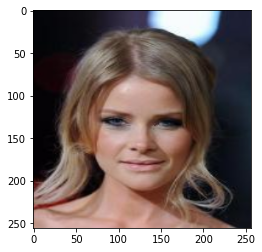

In [ ]:
df_attributes = initialize_celeba(30000)
attributesConsidered = 10
df_attributes_short = df_attributes.iloc[:, : attributesConsidered + 1]
print(df_attributes_short.shape)

dataset = celebAData(df_attributes_short)
tem = dataset.__getitem__(2)
plt.imshow(tem['img'])
print(tem["label"])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
torch.cuda.empty_cache()
def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).name,
                    " GPU" if obj.is_cuda else "",
                    " pinned" if obj.is_pinned else "",
                    pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).name,
                    type(obj.data).name,
                    " GPU" if obj.is_cuda else "",
                    " pinned" if obj.data.is_pinned else "",
                    " grad" if obj.requires_grad else "",
                    " volatile" if obj.volatile else "",
                    pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)
dump_tensors()

Total size: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: astor.all_symbols is deprecated.  Please use astor.symbol_data.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: astor.treewalk is deprecated.  Please use astor.tree_walk.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: astor.codegen is deprecated.  Please use astor.code_gen.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


## train

In [ ]:
df_attributes = initialize_celeba(20000)
attributesConsidered = 10
df_attributes_short = df_attributes.iloc[:, : attributesConsidered + 1]
# print(df_attributes_short.iloc[0])

# dataset = celebAData(df_attributes_short)
# tem = dataset.__getitem__(3)
# plt.imshow(tem['img'])
# print(tem["label"])

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
loss,acc = train_test("mobilenet",df_attributes_short,erro='bce',transforms=transforms_train)

attributes considered: 10
Epoch: 0
torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([64, 10])


IndexError: ignored

In [ ]:
x = torch.randn(3, 4)
print(x)
print(x.shape)
indices = torch.tensor([0, 2])
torch.index_select(x, 0, indices)


tensor([[-0.8236, -0.8601,  2.4808,  1.6487],
        [ 0.4876,  1.6169,  0.6075, -0.5025],
        [-0.4784,  1.0442, -0.6027, -0.0037]])
torch.Size([3, 4])


tensor([[-0.8236, -0.8601,  2.4808,  1.6487],
        [-0.4784,  1.0442, -0.6027, -0.0037]])

In [ ]:
from tqdm.notebook import tqdm
def train_test(modeltype,df_attributes,erro='ce',optimizertype='Adam',batch_size=64, epochs=5, transforms=None):
    # full_dataset = CustomData(transforms,train_path,trainimgs)
    print("=========================================================================================")
    print("=========================================================================================")
    full_dataset = celebAData(df_attributes, transforms)
    train_size = int(0.8 * len(full_dataset)) 
    test_size = len(full_dataset) - train_size

    # batch = 32
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    attributesConsidered = df_attributes.shape[1]-1
    print("attributes considered:", attributesConsidered)

    if modeltype == 'alexnet':
        model = AlexNet(attributesConsidered).to(device)
    elif modeltype == 'resnet':
        model = get_resnet(attributesConsidered)
        model = model.to(device)
    elif modeltype == 'mobilenet':
        model = MultiOutputModel().to(device)
    else:
        raise Exception("Enter a valid model type!")
    
    if optimizertype == 'Adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizertype == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0,
                            weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optimizertype == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    else:
        raise Exception("Enter a valid optimizer type!")

    if erro == 'ce':
        error = nn.CrossEntropyLoss().to(device)
    elif erro == 'ms':
        error = nn.MSELoss().to(device)
    elif erro == 'bce':
        error = nn.BCELoss().to(device)

    valid_loss_min = np.Inf

    losses = {'train' : [] } 
    accuracies = {'train' : []} 
    dataloaders = {
        'train':train_loader,
        'test':test_loader
    }
    for epoch in range(epochs):
        print('='*10)
        print("Epoch: {}".format(epoch))

        model.train()
        # for phase in ['train']:

        curr_loss = 0.0
        curr_acc = 0

        for dinputs in dataloaders["train"]:
            inputs = dinputs["img"].to(device)
            labels = dinputs["label"].to(device)

            outputs = model(inputs)
            print(outputs.shape)
            print(labels.shape)
            _, one_outputs = torch.max(outputs, 1)
            indexes = torch.LongTensor([i for i in range(attributesConsidered)]).to(device)
            asdf = torch.index_select(one_outputs, 1, indexes)
            print(asdf.shape)
            return
            loss = model.get_loss(one_output, labels)
            print(loss)
            curr_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return

            # _, preds = torch.max(outputs, 1)
            preds = outputs
            # print(preds.shape) 
            # print(labels.shape)
            # curr_loss += loss.item() * inputs.size(0)
            curr_acc += torch.sum(preds == labels.data)

        curr_loss = curr_loss / len(dataloaders["train"].sampler)
        curr_acc = curr_acc.double() / len(dataloaders["train"].sampler)
        
        losses["train"].append(curr_loss)
        accuracies["train"].append(curr_acc)
        # if epoch == epochs - 1:
        print("train" + ":")
        print('loss = {:.4f}     accuracy = {:.4f}'.format(curr_loss,curr_acc))
            # print()
        # train_losses.append(train_loss)
        # valid_losses.append(valid_loss)

    '''
    test code here
    '''
    model.eval()
    test_loss = 0.0
    test_acc = 0
    for dinputs in dataloaders["test"]:
        inputs = dinputs["img"].to(device)
        labels = dinputs["label"].to(device)

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()
        outputs = (outputs-torch.min(outputs))/(torch.max(outputs)-torch.min(outputs))
        labels = (labels-torch.min(labels))/(torch.max(labels)-torch.min(labels))
        loss = error(outputs, labels)

        # _, preds = torch.max(outputs, 1)
        preds = outputs
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(preds == labels.data)

    test_loss = test_loss / len(dataloaders["test"].sampler)
    test_acc = test_acc.double() / len(dataloaders["test"].sampler)
    print("test" + ":")
    print("loss: {:.4f}     accuracy: {:.4f}".format(test_loss, test_acc))

    return losses,accuracies    

### old train code

In [ ]:
from tqdm.notebook import tqdm
def train_test(modeltype,df_attributes,erro='ce',optimizertype='Adam',batch_size=64, epochs=5, transforms=None):
    # full_dataset = CustomData(transforms,train_path,trainimgs)
    print("=========================================================================================")
    print("=========================================================================================")
    full_dataset = celebAData(df_attributes, transforms)
    train_size = int(0.8 * len(full_dataset)) 
    test_size = len(full_dataset) - train_size

    # batch = 32
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("attributes considered:", df_attributes.shape[1]-1)

    if modeltype == 'alexnet':
        model = AlexNet(df_attributes.shape[1]-1).to(device)
    elif modeltype == 'resnet':
        model = get_resnet(df_attributes.shape[1]-1)
        model = model.to(device)
    else:
        raise Exception("Enter a valid model type!")
    
    if optimizertype == 'Adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizertype == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0,
                            weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optimizertype == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    else:
        raise Exception("Enter a valid optimizer type!")

    if erro == 'ce':
        error = nn.CrossEntropyLoss().to(device)
    elif erro == 'ms':
        error = nn.MSELoss().to(device)
    elif erro == 'bce':
        error = nn.BCELoss().to(device)

    valid_loss_min = np.Inf

    losses = {'train' : [] } 
    accuracies = {'train' : []} 
    dataloaders = {
        'train':train_loader,
        'test':test_loader
    }
    for epoch in range(epochs):
        print('='*10)
        print("Epoch: {}".format(epoch))

        model.train()
        # for phase in ['train']:

        curr_loss = 0.0
        curr_acc = 0

        for dinputs in dataloaders["train"]:
            inputs = dinputs["img"].to(device)
            labels = dinputs["label"].to(device)

            outputs = model(inputs)
            outputs = outputs.float()
            labels = labels.float()
            # print("labels shape", labels.shape)
            outputs = (outputs-torch.min(outputs))/(torch.max(outputs)-torch.min(outputs))
            labels = (labels-torch.min(labels))/(torch.max(labels)-torch.min(labels))
            # print(outputs)
            # print(labels)

            loss = error(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # _, preds = torch.max(outputs, 1)
            preds = outputs
            preds[outputs>=0.5] = 1
            preds[outputs<0.5] = 0
            # print("preds shape", preds.shape)
            # print("lebales. datashape", labels.data.shape)
            # print(preds.shape) 
            # print(labels.shape)
            curr_loss += loss.item() * inputs.size(0)
            # curr_acc += torch.sum(preds == labels.data)
            curr_acc += torch.sum(preds == labels.data)

        curr_loss = curr_loss / len(dataloaders["train"].sampler)
        curr_acc = curr_acc.double() / len(dataloaders["train"].sampler)
        
        losses["train"].append(curr_loss)
        accuracies["train"].append(curr_acc)
        # if epoch == epochs - 1:
        print("train" + ":")
        print('loss = {:.4f}     accuracy = {:.4f}'.format(curr_loss,curr_acc))
            # print()
        # train_losses.append(train_loss)
        # valid_losses.append(valid_loss)

    '''
    test code here
    '''
    model.eval()
    test_loss = 0.0
    test_acc = 0
    for dinputs in dataloaders["test"]:
        inputs = dinputs["img"].to(device)
        labels = dinputs["label"].to(device)

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()
        outputs = (outputs-torch.min(outputs))/(torch.max(outputs)-torch.min(outputs))
        labels = (labels-torch.min(labels))/(torch.max(labels)-torch.min(labels))
        loss = error(outputs, labels)

        # _, preds = torch.max(outputs, 1)
        preds = outputs
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(preds == labels.data)

    test_loss = test_loss / len(dataloaders["test"].sampler)
    test_acc = test_acc.double() / len(dataloaders["test"].sampler)
    print("test" + ":")
    print("loss: {:.4f}     accuracy: {:.4f}".format(test_loss, test_acc))

    return losses,accuracies    

In [ ]:
df_attributes = initialize_celeba(20000)
attributesConsidered = 10
df_attributes_short = df_attributes.iloc[:, : attributesConsidered + 1]
# print(df_attributes_short.iloc[0])

# dataset = celebAData(df_attributes_short)
# tem = dataset.__getitem__(3)
# plt.imshow(tem['img'])
# print(tem["label"])

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657))
])
loss,acc = train_test("resnet",df_attributes_short,erro='bce',transforms=transforms_train)


attributes considered: 10
Epoch: 0


KeyboardInterrupt: ignored

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/project-sepnu/data/neural network/Male_lfw.pth'))
model.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
with torch.no_grad():
    for images in test_loader:
        data = images['feat'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model(data.float())
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
        correct += (predicted == target).sum().item()


print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

In [ ]:
!unzip "/content/drive/MyDrive/CelebA/zipped/archive.zip"

Archive:  /content/drive/MyDrive/CelebA/zipped/archive.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 